In [7]:
#Importing Modules and Keys
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt 
import numpy as np
import math
import gmaps
from scipy.stats import linregress
from config import g_key
gmaps.configure(api_key=g_key)
from pprint import pprint
from config import openWeatherKey


In [8]:
#Pulling First CSV and filtering for desired columns
weatherDisasterCSV = "Resources/disaster_data.csv"
wDisaster_df = pd.read_csv(weatherDisasterCSV)
desiredColumns = ["Dis No", "Year", "Seq", "Disaster Subgroup", "Disaster Type", "Disaster Subtype", "Disaster Subsubtype", "Entry Criteria", "ISO", "Location", "Start Month", "End Month", "Total Deaths", "No Injured", "No Affected", "No Homeless", "Total Affected", "Insured Damages ('000 US$)", "Total Damages ('000 US$)", "CPI"]
wDisaster_df = wDisaster_df.loc[wDisaster_df["ISO"] == "USA", desiredColumns]
#wDisaster_df

#Creating Data Fram with Location name and Disaster Number
newData = { "Location": [], "Dis No": []}
for index, row in wDisaster_df.iterrows():
    if type(row["Location"]) is str:
        for location in row["Location"].split(","):
            newData["Location"].append(location)
            newData["Dis No"].append(row["Dis No"])
splitLocations_df = pd.DataFrame(newData)
#splitLocations_df

#Adding Columns for Lat / Long
splitLocations_df["Lat"] = ""
splitLocations_df["Long"] = ""
locations = splitLocations_df["Location"]
#splitLocations_df

#Pulling Coordnates from CSV that we created using OpenWeather API
coordCSV = "output_data/NEW_coordinates.csv"
coordLocations_df = pd.read_csv(coordCSV)
cleanedCoordsIndex = coordLocations_df.index
coordLocations_df = coordLocations_df.loc[:, ['Location', 'Dis No', 'Lat', 'Long']]
#coordLocations_df

#MMerging my Data Frames
Combined_df =pd.merge(wDisaster_df, coordLocations_df, on='Dis No')
#Combined_df

#Creating my Database for the 1 Quintant (North East) by filtering for Lat / Long
FirstQuintant1 = Combined_df.loc[Combined_df["Lat"] > 38, :].reset_index(drop=True)
FirstQuintant2 = FirstQuintant1.loc[FirstQuintant1["Long"] > -90, :].reset_index(drop=True)
#FirstQuintant2

#Filtering for columns we want to use in analysis
desiredColumns = ["Dis No","Year", "Seq", "Disaster Subgroup", "Disaster Type", "Disaster Subtype", "Disaster Subsubtype", "Entry Criteria", "ISO", "Start Month", "End Month", "Total Deaths", "No Injured", "No Affected", "No Homeless", "Total Affected", "Insured Damages ('000 US$)", "Total Damages ('000 US$)", "CPI","Location_y","Lat","Long"]
FirstQuintant = FirstQuintant2.loc[:, desiredColumns].reset_index(drop=True)
FirstQuintant.rename(columns={'Location_y': 'Location'}, inplace=True)
#FirstQuintant

#Creating a trimmed DF of dropped duplicates for more accurate calculations
FirstQuintantUniqueForCalc = FirstQuintant.drop_duplicates(subset="Dis No", keep="first")
#FirstQuintantUniqueForCalc

#Filtering, grouping and changing the names of columns for yearly analysis
Yearly_TotalsRaw = FirstQuintantUniqueForCalc.groupby("Year").sum()
desiredColumns = ["Total Deaths", "No Injured", "No Affected", "No Homeless", "Total Affected", "Insured Damages ('000 US$)", "Total Damages ('000 US$)"]
Yearly_Totals = Yearly_TotalsRaw.loc[:, desiredColumns].reset_index(drop=False)
Yearly_Totals.rename(columns={"Insured Damages ('000 US$)" : "Insured Damages", "Total Damages ('000 US$)" : "Total Damages"}, inplace=True)
Yearly_CountRaw = FirstQuintantUniqueForCalc.groupby("Year").count()
Yearly_Count = Yearly_CountRaw.loc[:, "Dis No"].reset_index(drop=False)
YearlyMerged = pd.merge(Yearly_Count, Yearly_Totals, on='Year')
#YearlyMerged


Text(0.5, 1.0, 'Total Damages and Insured Damages per Year')

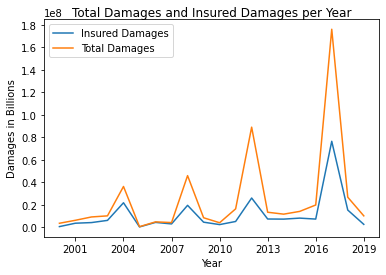

In [9]:
# Total Damanges and Insured Damanges per Year
PlotThis = ["Insured Damages","Total Damages"]
df = YearlyMerged
Damages = df.plot(kind="line",x="Year",y=PlotThis)
Damages.xaxis.set_major_locator(plt.MaxNLocator(8))
Damages.yaxis.set_major_locator(plt.MaxNLocator(10))
plt.ylabel('Damages in Billions')  
  
# displaying the title 
plt.title(label='Total Damages and Insured Damages per Year',  
          fontweight=10,  
          pad='2.0')

Text(0.5, 1.0, 'Disasters per Year')

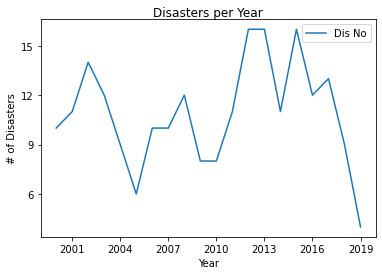

In [10]:
# Disasters per Year
PlotThis = ["Dis No"]
df = YearlyMerged
Homeless = df.plot(kind="line",x="Year",y=PlotThis)
Homeless.xaxis.set_major_locator(plt.MaxNLocator(8))
Homeless.yaxis.set_major_locator(plt.MaxNLocator(5))
plt.ylabel('# of Disasters')  
  
# displaying the title 
plt.title(label='Disasters per Year',  
          fontweight=10,  
          pad='2.0')

Text(0.5, 1.0, 'Total Death and Injuries per Year')

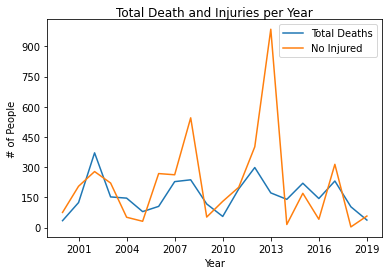

In [11]:
# Total Death and Injuries per Year
PlotThis = ["Total Deaths", "No Injured"]
df = YearlyMerged
DeathInjury = df.plot(kind="line",x="Year",y=PlotThis)
DeathInjury.xaxis.set_major_locator(plt.MaxNLocator(8))
DeathInjury.yaxis.set_major_locator(plt.MaxNLocator(10))

plt.ylabel('# of People')  
  
# displaying the title 
plt.title(label='Total Death and Injuries per Year',  
          fontweight=10,  
          pad='2.0')


Text(0.5, 1.0, 'Homeless due to Disasters per Year')

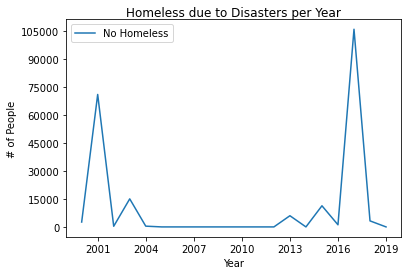

In [12]:
# Homeless due to Disasters per Year
PlotThis = ["No Homeless"]
df = YearlyMerged
Homeless = df.plot(kind="line",x="Year",y=PlotThis)
Homeless.xaxis.set_major_locator(plt.MaxNLocator(8))
Homeless.yaxis.set_major_locator(plt.MaxNLocator(10))

plt.ylabel('# of People')  
  
# displaying the title 
plt.title(label='Homeless due to Disasters per Year',  
          fontweight=10,  
          pad='2.0')

Text(0.5, 1.0, 'Types of Disasters per Year')

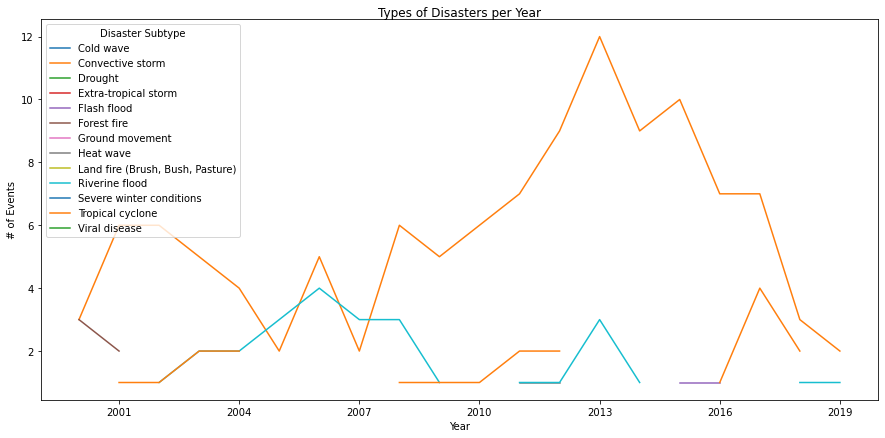

In [13]:
# Types of Disasters by Year
Types =  pd.DataFrame(FirstQuintantUniqueForCalc.groupby('Year')['Disaster Subtype'].value_counts())
df = Types
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
FirstQuintantUniqueForCalc.groupby('Year')['Disaster Subtype'].value_counts().unstack().plot(ax=ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.yaxis.set_major_locator(plt.MaxNLocator(8))

plt.ylabel('# of Events')  
  
# displaying the title 
plt.title(label='Types of Disasters per Year',  
          fontweight=10,  
          pad='2.0')

In [ ]:
# Leo's Disaster Type Analysis

In [14]:
areasAffected = len(FirstQuintant["Location"].unique())
#Distaster subtypes value counts into variables to use in the future 
regionDisTypesCount = FirstQuintant["Disaster Type"].value_counts()
regionDisSubTypeCount = FirstQuintant["Disaster Subtype"].value_counts()
#Print summary of total disaster count and areas affected
totalDisasterCount = len(FirstQuintantUniqueForCalc['Disaster Subtype'])
#DF for Total damages by subtype
regionalDisGroupby1 = FirstQuintantUniqueForCalc.groupby("Disaster Subtype").agg({"Location": "count", "Total Damages ('000 US$)" : "sum"})
#DF for Occurances of Disaster SubTypes plot
regionalDisGroupby = FirstQuintantUniqueForCalc.groupby(["Disaster Type", "Disaster Subtype"]).agg({"Location": "count", "Total Damages ('000 US$)" : "sum"})
#DF for Total affected by SubType
regionalDisGroupbyNoAff = FirstQuintantUniqueForCalc.groupby(["Disaster Subtype"]).agg({"No Homeless": "sum", "Total Deaths": "sum", "No Affected": "sum","Total Affected": "sum"})
regionalDisGroupbyNoAff = regionalDisGroupbyNoAff.drop(index="Drought")


print(f"There were {totalDisasterCount} total distaters in the Midwest Region\nThere {areasAffected} total areas affected")


There were 218 total distaters in the Midwest Region
There 156 total areas affected


In [15]:
#regionalDisGroupby

Text(0, 0.5, 'Occurance Count')

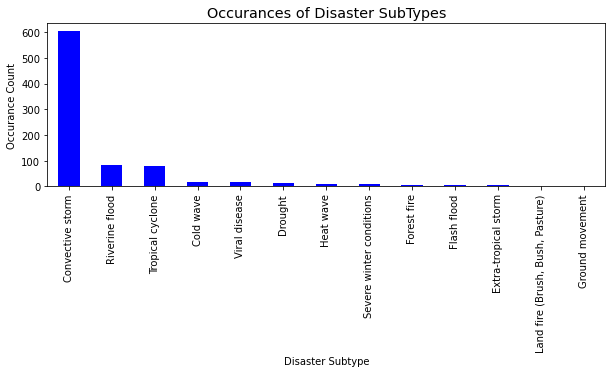

In [16]:
#Occurences by SubType
plt.figure(figsize=(10,3))

regionDisSubTypeCount.plot(kind="bar", facecolor="blue", rot=90)
plt.style.use('ggplot')
plt.title("Occurances of Disaster SubTypes")
plt.xlabel("Disaster Subtype")
plt.ylabel("Occurance Count")

Text(0, 0.5, 'Cost in US Dollars')

<Figure size 720x720 with 0 Axes>

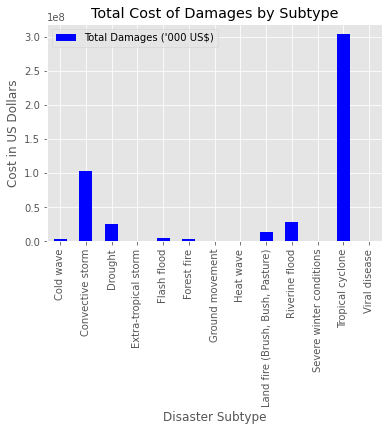

In [17]:
#Total damages by subtype
plt.figure(figsize=(10,10))

regionalDisGroupby1.plot(kind="bar", facecolor="blue", y="Total Damages ('000 US$)", rot=90)
plt.title("Total Cost of Damages by Subtype")
plt.xlabel("Disaster Subtype")
plt.ylabel("Cost in US Dollars")

Text(0, 0.5, 'Total')

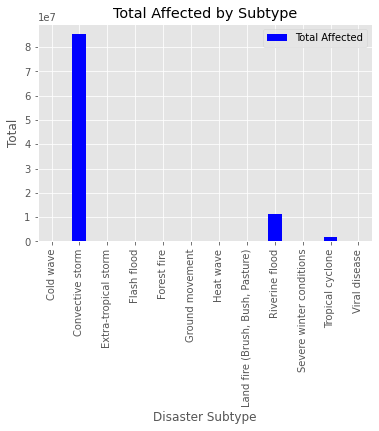

In [18]:
# Total affected by SubType
regionalDisGroupbyNoAff.plot.bar(use_index=True, y=["Total Affected"], rot=90, stacked=True, color={"blue": "Total Affected"})
plt.title("Total Affected by Subtype")
plt.xlabel("Disaster Subtype")
plt.ylabel("Total")

Text(0, 0.5, 'Number of People Displaced')

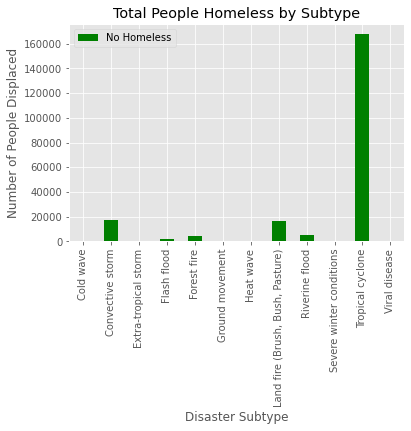

In [19]:
# Total Homeless by SubType
regionalDisGroupbyNoAff.plot.bar(use_index=True, y=["No Homeless"], rot=90, stacked=True, color={"green": "No Homeless"})
plt.title("Total People Homeless by Subtype")
plt.xlabel("Disaster Subtype")
plt.ylabel("Number of People Displaced")

Text(0, 0.5, 'Number of Deaths')

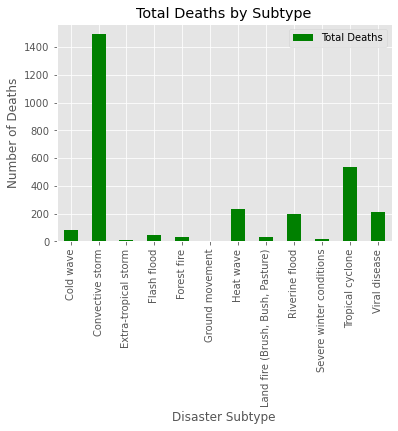

In [20]:
#Total Death by Subtype
regionalDisGroupbyNoAff.plot.bar(use_index=True, y=["Total Deaths"], rot=90, stacked=True, color={"green": "Total Deaths"})
plt.title("Total Deaths by Subtype")
plt.xlabel("Disaster Subtype")
plt.ylabel("Number of Deaths")

In [21]:
# Tyson's Stuff

In [22]:
#len(FirstQuintant["Location"].unique())
#FirstQuintant["Disaster Type"].unique()

In [23]:
trimmed_df = FirstQuintant.drop_duplicates(subset= "Dis No", keep="first")
Disastercount_df = trimmed_df.groupby(["Disaster Type", "Disaster Subtype"]).agg({"Location":"count","Total Damages ('000 US$)":"sum"})
locations = trimmed_df[["Lat", "Long"]]
ratings = trimmed_df["Total Damages ('000 US$)"].astype(float)
max_damages = max(trimmed_df["Total Damages ('000 US$)"])
year_list = trimmed_df["Year"].unique()
#year_list

yearly_max_dam = []
for year in year_list:
    yearly_df = trimmed_df.loc[trimmed_df["Year"] == year, ["Total Damages ('000 US$)"]].fillna(0)
    max_dam = max(yearly_df["Total Damages ('000 US$)"])
    yearly_max_dam.append(max_dam)  
#print(yearly_max_dam)

trimmed_year_df = trimmed_df.groupby(["Year"]).agg({"Total Damages ('000 US$)":"max"})
# trimmed_year_df = max(trimmed_year_df[trimmed_year_df["Total Damages ('000 US$)"]])

trimmed_year_df = trimmed_year_df.dropna()
trimmed_year_df["Max Dam"] = yearly_max_dam
#trimmed_year_df

In [24]:
trimmed_df.loc[trimmed_df["Year"] == 2019, ["Total Damages ('000 US$)"]]
trimmed_df["Total Damages ('000 US$)"].fillna(0)

0        166000.0
1        350000.0
3         28500.0
5             0.0
8             0.0
          ...    
939     5200000.0
941           0.0
942      235000.0
943    10000000.0
944           0.0
Name: Total Damages ('000 US$), Length: 218, dtype: float64

In [25]:
trimmed_year_df = trimmed_df.groupby(["Year"]).agg({"Total Damages ('000 US$)":"max"})
trimmed_year_df = trimmed_year_df.dropna()
trimmed_year_df
maxdamage_latlong_df = pd.merge(trimmed_year_df,trimmed_df, on=["Year","Total Damages ('000 US$)"], how="left")
maxdamage_latlong_df = maxdamage_latlong_df[["Year","Total Damages ('000 US$)","Location","Dis No","Lat","Long"]]
#maxdamage_latlong_df

locations1 = maxdamage_latlong_df[["Lat", "Long"]]
ratings1 = maxdamage_latlong_df["Total Damages ('000 US$)"].astype(float)
max_damages1 = max(maxdamage_latlong_df["Total Damages ('000 US$)"])

In [26]:
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights = ratings, dissipating=False, max_intensity=10000000,point_radius=1)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [27]:
info_box_content = """
<dl>
<dt>Year</dt><dd>{Year}</dd>
<dt>Disaster Number</dt><dd>{Dis No}</dd>
<dt>Total Damages</dt><dd>{Total Damages ('000 US$)}</dd>
</dl>
"""
year_info = [info_box_content.format(**row) for index, row in maxdamage_latlong_df.iterrows()]
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
locations1 = maxdamage_latlong_df[["Lat", "Long"]]
#Add marker to heat map
markers = gmaps.marker_layer(locations1,info_box_content=year_info)
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(height='420px'))

In [28]:
# Buckley's Linear Regression

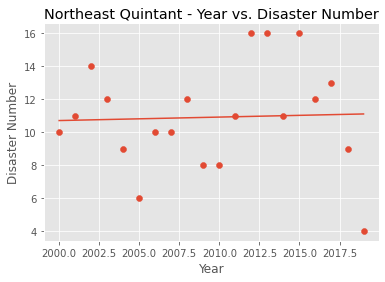

In [29]:
(slope,intercept,rvalue,pvalue,stderr) = linregress(YearlyMerged['Year'], YearlyMerged['Dis No'])
x = YearlyMerged['Year']
regressvalues = slope*x+intercept
plt.xlabel('Year')
plt.ylabel('Disaster Number')
plt.title('Northeast Quintant - Year vs. Disaster Number')
plt.plot(x,regressvalues)
plt.scatter(x,YearlyMerged['Dis No'])
plt.show()

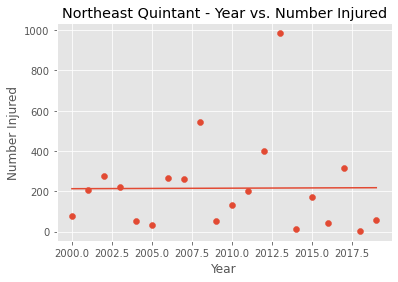

In [30]:
(slope,intercept,rvalue,pvalue,stderr) = linregress(YearlyMerged['Year'], YearlyMerged['No Injured'])
x = YearlyMerged['Year']
regressvalues = slope*x+intercept
plt.xlabel('Year')
plt.ylabel('Number Injured')
plt.title('Northeast Quintant - Year vs. Number Injured')
plt.plot(x,regressvalues)
plt.scatter(x,YearlyMerged['No Injured'])
plt.show()